## Classification With Fusion Data

The aim of this notebook is to predict if a shot will become unstable, at a given state in time.


In reality, our dataset is comprised of multiple shots, where each shot has individual time readings.

| Shot Number     | Time Step            | Feature 1       | Feature 2       |
|-----------------|----------------------|-----------------|-----------------|
| 1               |       $t_0$          | -               | -               |
| 1               |       $t_1$          | -               | -               |
| 1               |       $t_2$          | -               | -               |
| 1               |       ...            | -               | -               |
| 1               |       $t_m$          | -               | -               |
...
| Shot Number     | Time Step            | Feature 1       | Feature 2       |
|-----------------|----------------------|-----------------|-----------------|
| N               |       $t_0$          | -               | -               |
| N               |       $t_1$          | -               | -               |
| N               |       $t_2$          | -               | -               |
| N               |       ...            | -               | -               |
| N               |       $t_m$          | -               | -               |

In good approximation, we can treat individual readings in time as independent measurements and predict directly upon them.

You can think of this as a sort of state estimation:

Given state $S_i$, independent of $S_{j \neq i}$, we want to predict if the fusion reaction will remain stable.

Lets load our data and take a look at the features.

We will drop: 

__Disruptive__ - this is the binary label indicating whether or not a disruption has occured.

__Shot__ - this is an indexing variable for individual shots.

__time_until_disrupt__ - this will bias our results.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

df_classification = pd.read_csv("full_db-complete_classified_0.1s.csv",sep=',',index_col=None)
df_classification = df_classification.sample(frac=1.0) # Random shuffle shots
df_classification.head()

,z_error,radiated_fraction,beta_p,lower_gap,n_e,ssep,Wmhd,p_icrf,upper_gap,beta_n,...,Greenwald_fraction,shot,li,v_loop,time,q95,p_oh,p_rad,ip_error,disruptive
62088,0.000224,0.239726,0.118051,0.057133,1.602319e+20,-0.006157,21013.630859,1.499616e+02,0.108011,0.202260,...,0.302273,1120731013,1.490600,-1.340820,0.76,4.360332,6.241964e+05,1.496720e+05,95026.656250,0.0
4866,-0.000086,0.812605,0.357751,0.049962,2.913856e+20,-0.020430,101089.367188,3.090002e+06,0.106096,0.786824,...,0.448404,1120125013,1.246266,-0.555206,0.98,3.482309,8.174088e+05,3.175180e+06,-197800.687500,0.0
230288,0.001386,0.196351,0.233779,0.067215,1.642391e+20,0.012025,40044.164062,6.024199e+05,0.092780,0.379546,...,0.303460,1150903017,1.459251,-0.958060,1.36,4.614364,1.032290e+06,3.209775e+05,111.750000,0.0
267774,-0.002458,0.554460,0.252805,0.042377,2.968996e+20,-0.007001,73308.164062,9.061936e+01,0.099233,0.524115,...,0.423225,1160629017,1.306835,-0.992188,1.30,3.796449,1.181367e+06,6.550706e+05,-273172.375000,0.0
299712,-0.000193,0.176279,0.162788,0.047700,1.630099e+20,-0.029201,39853.851562,4.895486e+05,0.134947,0.372334,...,0.267748,1160817012,1.327647,1.568096,1.12,3.137148,1.221950e+06,3.017011e+05,129949.694949,0.0


Lets visualize our data.

array([[<AxesSubplot:title={'center':'z_error'}>,
        <AxesSubplot:title={'center':'radiated_fraction'}>,
        <AxesSubplot:title={'center':'beta_p'}>,
        <AxesSubplot:title={'center':'lower_gap'}>,
        <AxesSubplot:title={'center':'n_e'}>,
        <AxesSubplot:title={'center':'ssep'}>],
       [<AxesSubplot:title={'center':'Wmhd'}>,
        <AxesSubplot:title={'center':'p_icrf'}>,
        <AxesSubplot:title={'center':'upper_gap'}>,
        <AxesSubplot:title={'center':'beta_n'}>,
        <AxesSubplot:title={'center':'zcur'}>,
        <AxesSubplot:title={'center':'q0'}>],
       [<AxesSubplot:title={'center':'qstar'}>,
        <AxesSubplot:title={'center':'n_over_ncrit'}>,
        <AxesSubplot:title={'center':'ip'}>,
        <AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'dipprog_dt'}>,
        <AxesSubplot:title={'center':'p_lh'}>],
       [<AxesSubplot:title={'center':'n_equal_1_mode'}>,
        <AxesSubplot:title={'center':'time_until_di

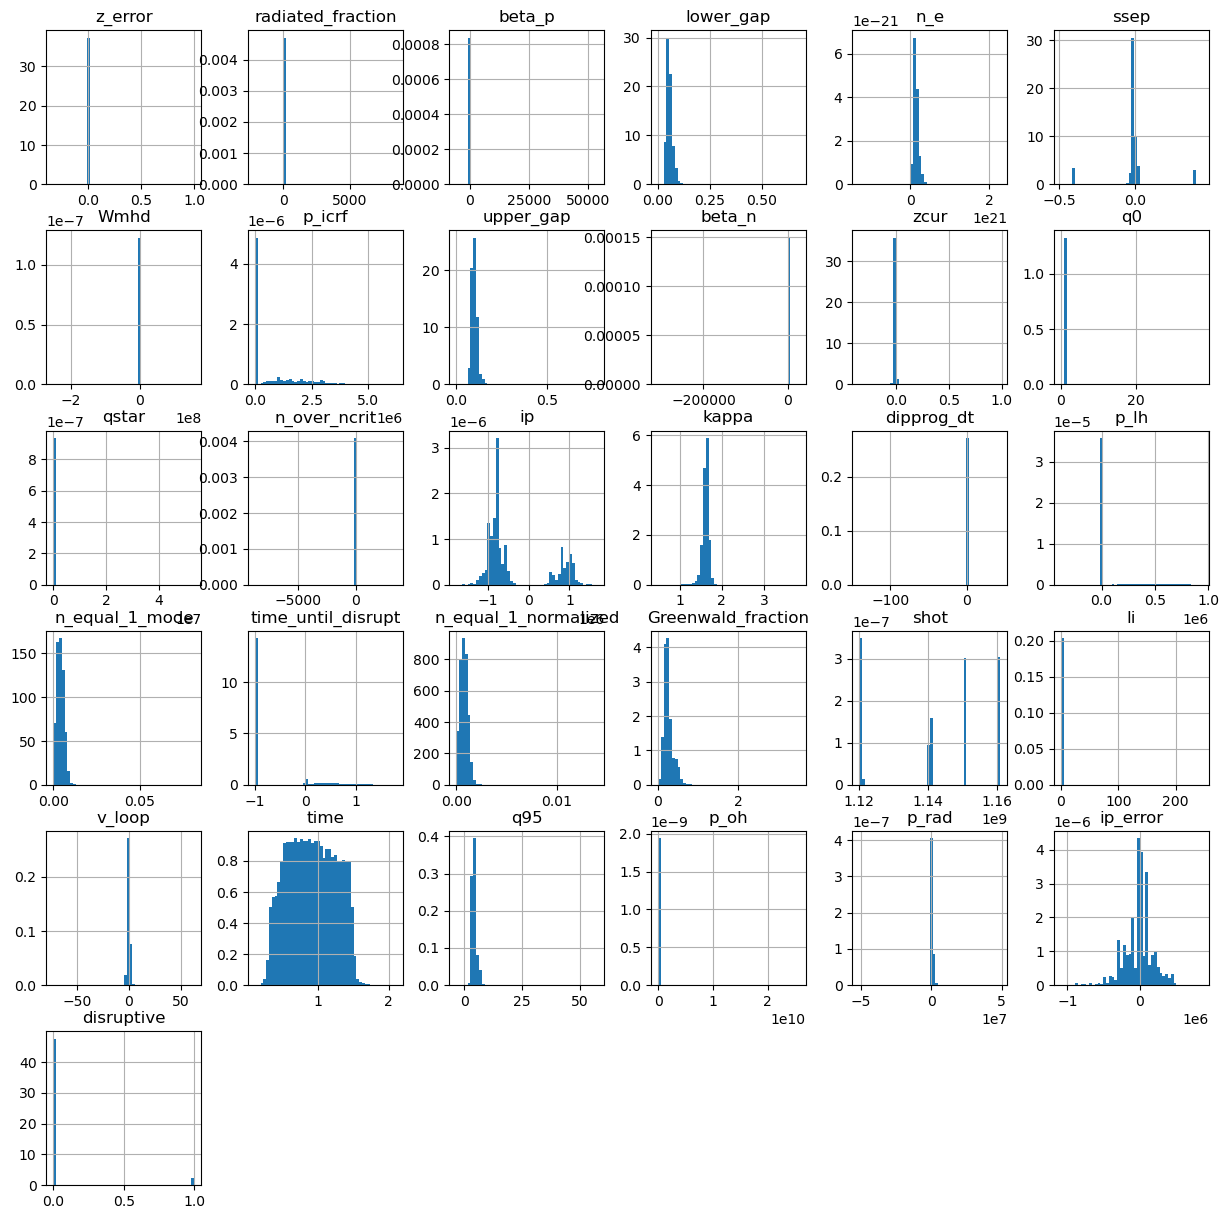

In [133]:
df_classification.hist(figsize=(15,15),bins=50,density=True)

### Preprocessing

We will create a train test split for this dataset, using the traditional 70/15/15% split.

We are also going to add a flag for taking the logarithm of time.

In [135]:
from sklearn.preprocessing import MinMaxScaler

def create_train_test_split(dataset):
    
    def return_x_y(dataframe):
        x = dataframe.drop(columns=['time_until_disrupt','shot','disruptive']).to_numpy()
        y = dataframe['disruptive'].values
        
        return x,y 
    
    Nt = int(0.7 * len(dataset))
    train = dataset[:Nt]
    test_val = dataset[Nt:]
    
    Nv = int(0.5 *len(test_val))
    val = test_val[:Nv]
    test = test_val[Nv:]
    print("Total dataset size: ",len(dataset))
    print("Number of Training data points: ",len(train))
    print("Number of Validation data points: ",len(val))
    print("Number of Testing data points: ",len(test))
    
    train_x,train_y = return_x_y(train)
    val_x,val_y = return_x_y(val)
    test_x,test_y = return_x_y(test)
    
    return train_x,train_y,val_x,val_y,test_x,test_y

train_x,train_y,val_x,val_y,test_x,test_y = create_train_test_split(df_classification)

Total dataset size:  314824
Number of Training data points:  220376
Number of Validation data points:  47224
Number of Testing data points:  47224


Lets scale our data. Here we will use MinMax scaling on the interval (-1,1). You can experiment with other scaling such as StandardScalers (z-score normalization) if you wish.

In [139]:
feature_scaler = MinMaxScaler((-1,1))
feature_scaler.fit(df_classification.drop(columns=['time_until_disrupt','shot','disruptive']).to_numpy()) # Lets use global statistics for simplicity here.

x_train_scaled = feature_scaler.transform(train_x.astype('float32'))
x_val_scaled = feature_scaler.transform(val_x.astype('float32'))
x_test_scaled = feature_scaler.transform(test_x.astype('float32'))

print("Features")
print("Training:",x_train_scaled.max(),x_train_scaled.min())
print("Validation:",x_val_scaled.max(),x_val_scaled.min())
print("Testing:",x_test_scaled.max(),x_test_scaled.min())

y_train_scaled = train_y.copy().astype('float32')
y_val_scaled = val_y.copy().astype('float32')
y_test_scaled = test_y.copy().astype('float32')

print(" ")
print("Targets")
print("Training:",y_train_scaled.max(),y_train_scaled.min())
print("Validation:",y_val_scaled.max(),y_val_scaled.min())
print("Testing:",y_test_scaled.max(),y_test_scaled.min())

print("Features shape: ",x_train_scaled.shape)

Features
Training: 1.0000001 -1.0
Validation: 0.99999994 -1.0
Testing: 1.0 -1.0
 
Targets
Training: 1.0 0.0
Validation: 1.0 0.0
Testing: 1.0 0.0
Features shape:  (220376, 28)


### Model Definition

We will use a simple Deep Neural Network (DNN), commonly referred to as a Multi-Layer Perceptron (MLP).

We are going to make this as explicit as possible for clarity. We could use nn.Sequential to package this more neatly if we so choose, and also be more dynamic in our model creation.

In [163]:
import torch
from torch import nn
from torch.nn import BatchNorm1d

class MLP(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(MLP, self).__init__()

        self.init_layer = nn.Linear(input_shape,64)
        self.B0 = nn.BatchNorm1d(64)
        self.L1 = nn.Linear(64,256)
        self.B1 = nn.BatchNorm1d(256)
        self.L2 = nn.Linear(256,512)
        self.B2 = nn.BatchNorm1d(512)
        self.L3 = nn.Linear(512,256)
        self.B3 = nn.BatchNorm1d(256)
        self.L4 = nn.Linear(256,128)
        self.B4 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128,output_shape)
        self.activation = nn.SELU()
        self.output_activation = nn.Sigmoid()
    def forward(self,x):

        x = self.activation(self.B0(self.init_layer(x))) # SELU(BNorm(Linear(x)))
        x = self.activation(self.B1(self.L1(x)))
        x = self.activation(self.B2(self.L2(x)))
        x = self.activation(self.B3(self.L3(x)))
        x = self.activation(self.B4(self.L4(x)))
        x = self.output_activation(self.output(x)) # Sigmoid is obvious choice here, constrain to probabalistic interval (0,1)

        return x
     
classifier = MLP(input_shape=x_train_scaled.shape[1],output_shape=1) # Singular output
print(classifier)

MLP(
  (init_layer): Linear(in_features=28, out_features=64, bias=True)
  (B0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=64, out_features=256, bias=True)
  (B1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=256, out_features=512, bias=True)
  (B2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L3): Linear(in_features=512, out_features=256, bias=True)
  (B3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L4): Linear(in_features=256, out_features=128, bias=True)
  (B4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (activation): SELU()
  (output_activation): Sigmoid()
)


Lets see if we get output.

In [164]:
classifier(torch.tensor(x_train_scaled[:3]).float())

tensor([[0.5798],
        [0.3741],
        [0.5641]], grad_fn=<SigmoidBackward0>)

We are going to use built in pytorch functions for creating our data loading pipeline.
Since we have simple tabular data, we can use TensorDataset(x,y).

Note that we are going to need to convert these numpy arrays to torch.tensor() objects first.

In [165]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(x_train_scaled),torch.tensor(y_train_scaled.reshape(-1,1)))
val_dataset = TensorDataset(torch.tensor(x_val_scaled),torch.tensor(y_val_scaled.reshape(-1,1)))
test_dataset = TensorDataset(torch.tensor(x_test_scaled),torch.tensor(y_test_scaled.reshape(-1,1)))

We can also build custom datasets, which you will see in next weeks lectures on normalizing flows. We will explain in more detail how those work then, but for now you should have knowledge of the basic method of getting data from these objects.

In [166]:
train_dataset.__getitem__(0)

(tensor([-0.5048, -0.5983, -0.8101, -0.8315, -0.1853,  0.0391,  0.2243, -0.9937,
         -0.7235,  0.8404, -0.4978, -0.9521, -1.0000,  0.4307, -0.4364, -0.3332,
          0.5250, -0.4213, -0.9293, -0.9251, -0.8283, -0.9879,  0.0508, -0.3530,
         -0.7477, -0.9954,  0.0211,  0.2196]),
 tensor([0.]))

All pytorch datasets must have a __getitem__() function. This will be imporant when we want to pass these objects to a DataLoader(). Again, we will go into more detail on all of this next week. But lets get familiar with the basic usage.

We know that when we train deep learning models we will use batches of inputs to compute gradients. An efficient way to batch your data is to use the DataLoader() functions from pytorch. This will pass a series of random indices to your TensorDataset's __getitem__() function and form batches.

In [167]:
train_loader = DataLoader(train_dataset,batch_size=10)

for i,data in enumerate(train_loader):
    x = data[0]
    y = data[1]
    print("Batch {0}".format(i),"-> x shape: ",x.shape," y shape: ",y.shape)
    break

Batch 0 -> x shape:  torch.Size([10, 28])  y shape:  torch.Size([10, 1])


Now lets create a function to return dataloaders for the three datasets we have created.

In [168]:
# Create dataloaders to iterate.
# We take as input the three TensorDatasets along with the batch sizes we want to use.
def CreateLoaders(train_dataset,val_dataset,test_dataset,train_batch,val_batch,test_batch):
    train_loader = DataLoader(train_dataset,
                            batch_size=train_batch,
                            shuffle=True)
    val_loader =  DataLoader(val_dataset,
                            batch_size=val_batch,
                            shuffle=False)
    test_loader =  DataLoader(test_dataset,
                            batch_size=val_batch,
                            shuffle=False)
    return train_loader,val_loader,test_loader

train_loader,val_loader,test_loader = CreateLoaders(train_dataset,val_dataset,test_dataset,10,10,10)

### Training Function

We almost have everything we need to start training our model.

1. Datasets in a pytorch format.
2. DataLoaders for batch creation.
3. A training function - lets build this.

Lets write the training function in such a way that we can use it for any network.

There are two main components:

Training loop

Validation loop

We also need a clever way to store our parameters. Lets use a dictionary to do this.

Note that we are going to assume GPU usage here, so use your notebook on sciclone!

You can see the information regarding your GPU with the command below:

In [17]:
!nvidia-smi

Fri Jun  7 09:23:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.68                 Driver Version: 551.68         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   34C    P8             19W /  450W |    1029MiB /  24564MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

If you don't see an output with the above command please let me know and we will sort it.

In [169]:
config = {"seed":8,
          "name": "MyClassifier",
          "run_val":1,
          "model": {
               "input_shape":28,
               "output_shape": 1,
           },
          "optimizer": {
                "lr": 7e-4,
            },
          "num_epochs": 5,
          "dataloader": {
            "train": {
                "batch_size": 64
            },
            "val": {
                "batch_size": 64
            },
            "test": {
                "batch_size": 64
            },
          },
            "output": {
                "dir":"./"
            }
}

Below is our training function. It will operate as follows:

1. We set seeds for commonly used packages for reproducability. 
2. Create a directory with name corresponding to the name field in the above dictionary.
3. We create our dataloaders - we only need train/val, but test will be created anyways and not used.
4. We create an instance of our MLP (funciton defined above)
5. We create an instance of an optimizer - Adam.
6. Define a learning rate scheduler - CosineAnnealing. We will see what this looks like graphically.
7. Define our loss function - BCE
8. For each epoch iterate over all batches in the training loader and train.
9. At the end of each epoch, iterate over the validation loader - DO NOT apply gradients.

In [170]:
import os
import json
import random
import pkbar
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import datetime
import shutil
import time
import numpy as np

def trainer(config,train_dataset,val_dataset,test_dataset):
    # Setup random seed
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    random.seed(config['seed'])
    torch.cuda.manual_seed(config['seed'])

    # Create experiment name
    exp_name = config['name'] 
    print(exp_name)

    # Create directory structure
    output_folder = config['output']['dir']
    output_path = os.path.join(output_folder,exp_name)
    if os.path.exists(output_path):
        timestamp = time.time()
        dt_object = datetime.datetime.fromtimestamp(timestamp)
        formatted_time = dt_object.strftime('%H_%M_%S')
        output_path = output_path +"_"+ str(formatted_time)
        
    os.mkdir(output_path)
    
    with open(os.path.join(output_path,'config.json'),'w') as outfile:
        json.dump(config, outfile)


       # Load the dataset
    print('Creating Loaders.')
    train_batch_size = config['dataloader']['train']['batch_size']
    val_batch_size = config['dataloader']['val']['batch_size']
    test_batch_size = config['dataloader']['val']['batch_size']

    train_loader,val_loader,test_loader = CreateLoaders(train_dataset,val_dataset,test_dataset,train_batch_size,val_batch_size,test_batch_size)
    
    history = {'train_loss':[],'val_loss':[],'lr':[]}


    print("Training Size: {0}".format(len(train_loader.dataset)))
    print("Validation Size: {0}".format(len(val_loader.dataset)))

    # Create the model
    input_shape = config['model']['input_shape']
    output_shape = config['model']['output_shape']
    net = MLP(input_shape=input_shape,output_shape=output_shape)
    t_params = sum(p.numel() for p in net.parameters())
    print("Network Parameters: ",t_params)
    device = torch.device('cuda')
    net.to('cuda')

    # Optimizer
    num_epochs=int(config['num_epochs'])
    lr = float(config['optimizer']['lr'])

    optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, net.parameters())), lr=lr)
    num_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_steps, last_epoch=-1,
                                                           eta_min=0)

    startEpoch = 0
    global_step = 0

    print('===========  Optimizer  ==================:')
    print('      LR:', lr)
    print('      num_epochs:', num_epochs)
    print('')
    
    
    # Loss Function 
    loss_function = nn.BCELoss()
    for epoch in range(startEpoch,num_epochs):

        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=num_epochs, width=20, always_stateful=False)

        net.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            input  = data[0].to('cuda').float()
            y = data[1].to('cuda').float()

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                y_hat = net(input)
                
            #print(y_hat)
            
            #print(y_hat)
            loss = loss_function(y_hat,y)
            train_acc = (torch.sum(torch.round(y_hat) == y)).item() / len(y)

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.01,error_if_nonfinite=True)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * input.shape[0]
            kbar.update(i, values=[("loss", loss.item()),("train_acc",train_acc)])
            global_step += 1


        history['train_loss'].append(running_loss / len(train_loader.dataset))
        history['lr'].append(scheduler.get_last_lr()[0])


        ######################
        ## validation phase ##
        ######################
        if bool(config['run_val']):
            net.eval()
            val_loss = 0.0
            val_acc = 0.0
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    input  = data[0].to('cuda').float()
                    y = data[1].to('cuda').float()
                    y_hat = net(input)
                    loss = loss_function(y_hat,y)
                    
                    val_acc += (torch.sum(torch.round(y_hat) == y)).item() / len(y)
                    val_loss += loss

            val_loss = val_loss.cpu().numpy() / len(val_loader)
            val_acc /= len(val_loader)
            history['val_loss'].append(val_loss)

            kbar.add(1, values=[("val_loss", val_loss.item()),("val_acc",val_acc)])

            name_output_file = config['name']+'_epoch{:02d}_val_loss_{:.6f}.pth'.format(epoch, val_loss)

        else:
            kbar.add(1,values=[('val_loss',0.)])
            name_output_file = config['name']+'_epoch{:02d}_train_loss_{:.6f}.pth'.format(epoch, running_loss / len(train_loader.dataset))

        filename = os.path.join(output_path, name_output_file)

        checkpoint={}
        checkpoint['net_state_dict'] = net.state_dict()
        checkpoint['optimizer'] = optimizer.state_dict()
        checkpoint['scheduler'] = scheduler.state_dict()
        checkpoint['epoch'] = epoch
        checkpoint['history'] = history
        checkpoint['global_step'] = global_step

        torch.save(checkpoint,filename)

        print('')

In [171]:
trainer(config,train_dataset,val_dataset,test_dataset)

MyClassifier
Creating Loaders.
Training Size: 220376
Validation Size: 47224
Network Parameters:  316865
===========  Optimizer  ==================:
      LR: 0.0007
      num_epochs: 5

Epoch: 1/5
3444/3444 [====================] - 38s 11ms/step - loss: 0.1444 - train_acc: 0.9592 - val_loss: 0.1161 - val_acc: 0.9637

Epoch: 2/5
3444/3444 [====================] - 40s 12ms/step - loss: 0.1106 - train_acc: 0.9668 - val_loss: 0.1090 - val_acc: 0.9678

Epoch: 3/5
3444/3444 [====================] - 40s 12ms/step - loss: 0.0970 - train_acc: 0.9707 - val_loss: 0.0940 - val_acc: 0.9706

Epoch: 4/5
3444/3444 [====================] - 41s 12ms/step - loss: 0.0877 - train_acc: 0.9735 - val_loss: 0.0791 - val_acc: 0.9751

Epoch: 5/5
3444/3444 [====================] - 41s 12ms/step - loss: 0.0828 - train_acc: 0.9746 - val_loss: 0.0775 - val_acc: 0.9756



Lets take a look at what the learning rate scheduler has done for us:

In [173]:
dicte = torch.load(os.path.join(config['name'],os.listdir("MyClassifier")[-1]))
print(dicte.keys())

dict_keys(['net_state_dict', 'optimizer', 'scheduler', 'epoch', 'history', 'global_step'])


Within each .pth file, we have stored the weights at a specific epoch, along with a variety of other useful information. First lets plot the training and validation losses, along with the learning rate.

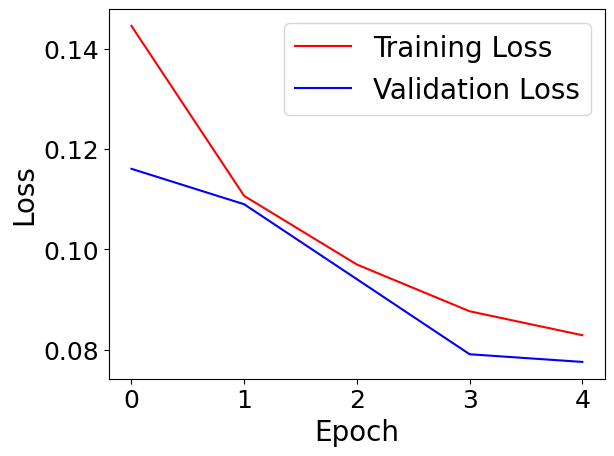

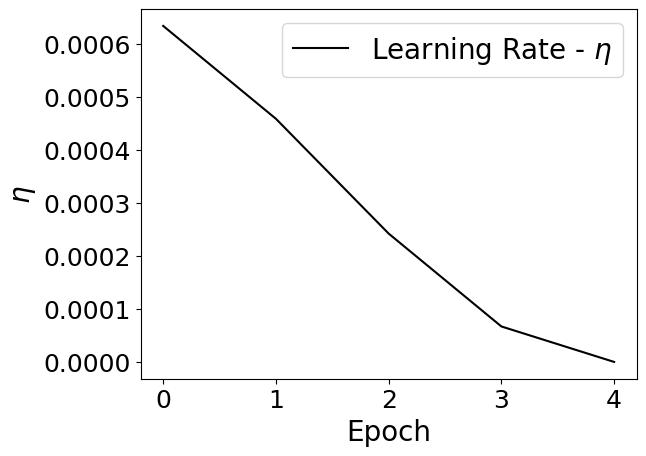

In [174]:
import matplotlib.pyplot as plt

train_loss = dicte['history']['train_loss']
val_loss = dicte['history']['val_loss']
learning_rate = dicte['history']['lr']

plt.plot(train_loss,'r-',label="Training Loss")
plt.plot(val_loss,'b-',label='Validation Loss')
plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.show()

plt.plot(learning_rate,'k-',label=r"Learning Rate - $\eta$")
plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel(r'$\eta$',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.show()

Notice how we have decreased the learning rate at each step corresponding to a cosine distribution. Specifically, we follow the formula below:



$\eta_{t} = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right)$

$\eta_{t+1} = \eta_{t} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 - \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right)$

where:

- $\eta_{t}$ is the learning rate at time \(t\),
- $\eta_{t+1}$ is the learning rate at time \(t+1\),
- $\eta_{\text{min}}$ is the minimum learning rate,
- $\eta_{\text{max}}$ is the maximum learning rate,
- $T_{\text{cur}}$ is the current time step,
- $T_{\text{max}}$ is the maximum time step.


with $T_{\text{cur}} \neq (2k+1)T_{\text{max}}$,

and $ T_{\text{cur}} = (2k+1)T_{\text{max}}. $





### Testing the Performance 

We have trained our model, and at each epoch we have saved the weights of the model to .pth file. This will be located in a folder corresponding to the “name” field of the config dictionary.

Lets load in the model, and look at some metrics.

In [175]:
input_shape = config['model']['input_shape']
output_shape = config['model']['output_shape']
net = MLP(input_shape=input_shape,output_shape=output_shape)
t_params = sum(p.numel() for p in net.parameters())
print("Network Parameters: ",t_params)
device = torch.device('cuda')
net.to('cuda')

dicte = torch.load(os.path.join(config['name'],os.listdir("MyClassifier")[-1]))
net.load_state_dict(dicte["net_state_dict"])

Network Parameters:  316865


<All keys matched successfully>

In [176]:
test_loader = DataLoader(test_dataset,batch_size=config['dataloader']['test']['batch_size'])
net.eval() # Eval mode 

predictions = []
y_true = []
kbar = pkbar.Kbar(target=len(test_loader), width=20, always_stateful=False)
for i,data in enumerate(test_loader):
    x = data[0].to('cuda').float()
    y_true.append(data[1].numpy())
    
    with torch.set_grad_enabled(False): # Same as with torch.no_grad():
        y_hat = net(x).detach().cpu().numpy()
            
    predictions.append(y_hat)
    
    kbar.update(i)
    
predictions = np.concatenate(predictions)
y_true = np.concatenate(y_true)

732/738 [==================>.] - ETA: 0s

Lets look at the ROC Curve.

AUC: 0.96


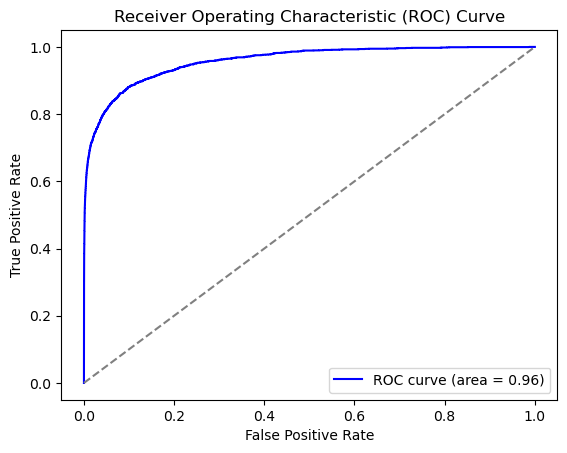

In [177]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_true, predictions)
print(f"AUC: {auc:.2f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Imbalanced Dataset

As you may have noticed (we brushed it under the rug), the class imbalance in our dataset is very large.

Our AUC is very good, but is this a good representation of our model performance? Lets take a look.

In [180]:
print("% of Data that is disruptive: ",len(df_classification[df_classification.disruptive == 1.0]) * 100 / len(df_classification))
print("% of Data that is NOT disruptive: ",len(df_classification[df_classification.disruptive == 0.0]) * 100 / len(df_classification))

% of Data that is disruptive:  4.8420704901786396
% of Data that is NOT disruptive:  95.15792950982136


Confusion Matrix:
 [[44876   122]
 [  998  1228]]


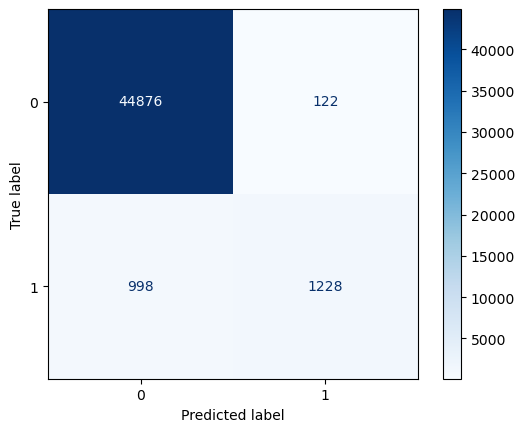

In [191]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

cm = confusion_matrix(y_true, predictions.round())
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We know that that class $1$ is underpresented. However, this is the class were more interested in! We need metrics that will give us information on how well our model is able to predict this class. Lets use $Recall$:

$Recall = \frac{TP}{TP + FN} $

Where,

$TP$ = True Positive Rate - Out of N true positives, how many do I correctly predict as 1?

$FN$ = False Negative Rate - Out of N true positives, how many do I incorrectly predict as 0?

In [190]:
print(classification_report(y_true,predictions.round()))

# Compute metrics
precision = precision_score(y_true, predictions.round())
recall = recall_score(y_true, predictions.round())
f1 = f1_score(y_true, predictions.round())

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     44998
         1.0       0.91      0.55      0.69      2226

    accuracy                           0.98     47224
   macro avg       0.94      0.77      0.84     47224
weighted avg       0.98      0.98      0.97     47224

Precision: 0.9096296296296297
Recall: 0.5516621743036837
F1 Score: 0.6868008948545862


You can see that our recall is extremely poor. On average, we predict class 1 correctly about ~50 % of the time.


Now I want you to try and improve the performance, specifically on class 1. Below we outline two different approaches. Feel free to pick the one you are more comfortable with, or try both.

### Simple Downsampling

A very easy way to deal with this is to downsample one of the classes such that the statistics at training are approximately equal. 

Q: What are the reprocussions of doing this?

### Class Weighting in the loss function

Another, perhaps more complicated, way to deal with this is through weighting of the individual loss contributions. For example, we could consider a weighting scheme such that the positive class contributes twice as much.

If you choose to go this route, you will need to do a little research into class reweighting with BinaryCrossEntropy. Specifically, you may way to look at the documentation for the pytorch BCE - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

Q: What are the reprocussions of doing this?